In [1]:
import pandas as pd 
import numpy as np 


In [2]:
#Reading the Tweets Csv and Creating a Dataframe
dataframe = pd.read_csv('Tweets.csv')
dataframe

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [3]:
#We only need the text and airline_sentiment columns so we convert the dataframe.

reviewed_df = dataframe[['text' , 'airline_sentiment']]
reviewed_df
reviewed_df.shape

(14640, 2)

In [4]:
#Since this is a binary classification we don't need the neutral sentiment so we remove it.

reviewed_df = reviewed_df[reviewed_df['airline_sentiment'] != 'neutral']
reviewed_df['airline_sentiment'].value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

In [5]:
#Since data are categorical we have to convert them to numerical values

sentiment = reviewed_df['airline_sentiment'].factorize()
sentiment

#0:positive
#1:negative

(array([0, 1, 1, ..., 0, 1, 1]),
 Index(['positive', 'negative'], dtype='object'))

In [6]:
#We now have to convert the text data to an array of vector embeddings using the  bag-of-words model
#First retrieving the data

text = reviewed_df['text'].values
text


array(["@VirginAmerica plus you've added commercials to the experience... tacky.",
       '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
       "@VirginAmerica and it's a really big bad thing about it", ...,
       '@AmericanAir thank you we got on a different flight to Chicago.',
       "@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc",
       "@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??"],
      dtype=object)

In [7]:
#Next we have to tokenize the words using Tokenizer to create tokens.
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)

In [8]:
#We have now associated numbers and numbers
#We have to replace now the words with their assigned numbers and padding the sentences so they all have equal length

encoded_docs = tokenizer.texts_to_sequences(text)

from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_sequence =  pad_sequences(encoded_docs,maxlen = 200)

Text Classifier

In [9]:
#We will use the LSTM layers which include 
#i) Embedding layer
#ii)LSTM layer
#iii)Dense Layer
#We will also use the dropout regulariation method in order to avoid overfitting and create a more robust model
vocab_size = len(tokenizer.word_index) + 1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           423488    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 440,139
Trainable params: 440,139
Non-trainable params: 0
__________________________________________________

In [10]:
history = model.fit(padded_sequence,sentiment[0],validation_split =0.2,epochs=5 ,batch_size=32)

Epoch 1/5
289/289 [==============================] - 78s 258ms/step - loss: 0.3694 - accuracy: 0.8438 - val_loss: 0.2060 - val_accuracy: 0.9194
Epoch 2/5
289/289 [==============================] - 68s 234ms/step - loss: 0.1802 - accuracy: 0.9333 - val_loss: 0.1646 - val_accuracy: 0.9407
Epoch 3/5
289/289 [==============================] - 66s 228ms/step - loss: 0.1199 - accuracy: 0.9567 - val_loss: 0.1833 - val_accuracy: 0.9342
Epoch 4/5
289/289 [==============================] - 66s 228ms/step - loss: 0.0775 - accuracy: 0.9735 - val_loss: 0.1815 - val_accuracy: 0.9372
Epoch 5/5
289/289 [==============================] - 66s 228ms/step - loss: 0.0529 - accuracy: 0.9832 - val_loss: 0.2153 - val_accuracy: 0.9389


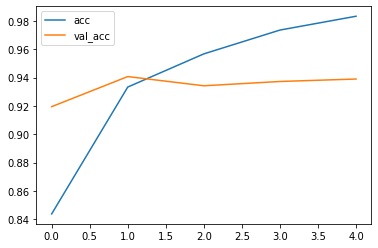

<Figure size 432x288 with 0 Axes>

In [14]:
#Here we plot the difference between the accuracy of the train-validation sets
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label = 'acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

plt.savefig('accuracy.jpg')

In [19]:
history.history

{'loss': [0.3693971633911133,
  0.18017269670963287,
  0.11986672878265381,
  0.07750042527914047,
  0.052940767258405685],
 'accuracy': [0.8438041806221008,
  0.933275580406189,
  0.9566724300384521,
  0.9734618663787842,
  0.983210563659668],
 'val_loss': [0.20595408976078033,
  0.1646144688129425,
  0.1833076775074005,
  0.181483656167984,
  0.21528133749961853],
 'val_accuracy': [0.9194456338882446,
  0.9406669735908508,
  0.934170663356781,
  0.9372022747993469,
  0.9389346241950989]}

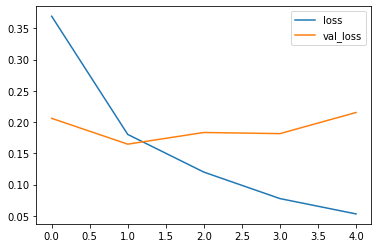

<Figure size 432x288 with 0 Axes>

In [20]:
#Here we plot the loss between val-train sets

plt.plot(history.history['loss'] ,label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

plt.savefig('loss.jpg')

In [32]:
#Function to analyze the result

def predict(text):
    tt = tokenizer.texts_to_sequences([text])
    tt = pad_sequences(tt , maxlen=200)
    prediction = int(model.predict(tt).round().item())
    print("Predicted label: ", sentiment[1][prediction])


test1 = 'This was the best flight of my life'
predict(test1)

test2 = 'This was the worst flight ever'
predict(test2)

test3 = 'It sucked'
predict(test3)

test4 = 'Beautiful service'
predict(test4)

Predicted label:  positive
Predicted label:  negative
Predicted label:  negative
Predicted label:  positive
